In [0]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/capstone_code")
sys.path.append("/content/drive/My Drive/capstone_code/p_file")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from visualization.plotting import plot_pose, plot_pose_visible

data = pd.read_csv('./processed_penn_data.csv', index_col=[0]).reset_index(drop=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [44]:
from preprocessing.serialization import serialize_data_clf

nframe = 1

train_input, train_label, label_encoder =  serialize_data_clf(nframe, data, n_aug=0, skip_frame=1, save=True, save_path="./serialized_data")

from sklearn.model_selection import train_test_split
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.2)

Creating data...


In [0]:
import os
import scipy.io
import pandas as pd
import numpy as np

class classification_model:
    def __init__(self, save_dir, nframe, n_class=15, n_latent_layer = 3, latent_unit = 100, dropout_rate = 0.2, lr = 0.001, early_stop=True):
        from keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
        from keras.models import Model
        from keras.optimizers import Adam, RMSprop, Adadelta 
        # if save_dir:
        #     from keras.models import load_model
        #     self.model = load_model(save_dir)
        self.early_stop = early_stop
        self.save_dir = save_dir
        inputs = Input(shape=(nframe, 13*3))
        x = LSTM(latent_unit, return_sequences=True)(inputs)
        for _ in range(n_latent_layer-1):
            x = Dropout(dropout_rate)(x)
            x = LSTM(latent_unit, return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)
        x = LSTM(latent_unit)(x)
        x = Dropout(dropout_rate)(x)
        pred = Dense(n_class, activation='softmax')(x)

        self.model = Model(inputs=inputs, outputs=pred)
        self.optimizer = RMSprop(lr=lr)
        self.model.compile(optimizer=self.optimizer,
                      loss='categorical_crossentropy',
                      metrics=['acc'])

    def training(self, train_input, train_label, val_input, val_label, n_epoch=50):
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        cp = ModelCheckpoint(self.save_dir, save_best_only=True)
        es = EarlyStopping(monitor="val_acc")

        if self.early_stop:
            self.history = self.model.fit(train_input, train_label, epochs=n_epoch, batch_size=128, validation_data=(val_input, val_label), callbacks=[es, cp])
        else: self.history = self.model.fit(train_input, train_label, epochs=n_epoch, batch_size=128, validation_data=(val_input, val_label), callbacks=[cp])
        return self.history

    def training_generator(self, train_generator, val_generator, n_step, n_step_val, n_epoch=50):
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        cp = ModelCheckpoint(self.save_dir, save_best_only=True)
        es = EarlyStopping(monitor="val_acc")
        if self.early_stop:
            self.history = self.model.fit_generator(generator=train_generator, epochs=n_epoch, steps_per_epoch=n_step, validation_data=val_generator, validation_steps=n_step_val, callbacks=[es, cp])
        else: self.history = self.model.fit_generator(generator=train_generator, epochs=n_epoch, steps_per_epoch=n_step, validation_data=val_generator, validation_steps=n_step_val, callbacks=[cp])
        return self.history

    def predict(self, _input):
        return self.model.predict(_input)

In [0]:
from models.data_generator import data_generator_clf

train_generator = data_generator_clf(train_input, train_label, batch_size=64)
val_generator = data_generator_clf(val_input, val_label, batch_size=64, augmented=False)

In [0]:
save_path = "./the_test_model"
model_1 = classification_model(save_dir = save_path, nframe=nframe, early_stop=False)

history1 = model_1.training_generator(train_generator, val_generator, 500, 200, n_epoch=100)
np.array(history1.history['acc']).dump("./clf_h1_tacc")
np.array(history1.history['val_acc']).dump("./clf_h1_vacc")
np.array(history1.history['loss']).dump("./clf_h1_tlosss")
np.array(history1.history['val_loss']).dump("./clf_h1_vloss")

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





500/500 [==============================] - 40s 79ms/step - loss: 2.3374 - acc: 0.1998 - val_loss: 2.0764 - val_acc: 0.2776
Epoch 2/100
500/500 [==============================] - 35s 71ms/step - loss: 1.9659 - acc: 0.3284 - val_loss: 1.7928 - val_acc: 0.3963
Epoch 3/100
500/500 [==============================] - 35s 70ms/step - loss: 1.7093 - acc: 0.4177 - val_loss: 1.5392 - val_acc: 0.4716
Epoch 4/100
500/500 [==============================] - 35s 70ms/step - loss: 1.5742 - acc: 0.4644 - val_loss: 1.4023 - val_acc: 0.5152
Epoch 5/100
500/500 [==============================] - 35s 70ms/step - loss: 1.4325 - acc: 0.5135 - val_loss: 1.4974 - val_acc: 0.5102
Epoch 6/100
500/500 [==============================] - 34s 69ms/step - loss: 1.3315 - acc: 0.5467 - va

In [0]:
embedded = np.load('./embedded_full', allow_pickle=True)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
en = OneHotEncoder()
label = en.fit_transform(data['action'].values.reshape(-1,1)).toarray()
scaler = StandardScaler()
embedded = scaler.fit_transform(embedded[1:])
train_input, val_input, train_label, val_label = train_test_split(embedded, label, test_size=0.2)

In [0]:
train_input = train_input.reshape(train_input.shape[0], 1, train_input.shape[1])
val_input = val_input.reshape(val_input.shape[0], 1, val_input.shape[1])

In [0]:
class classification_model_latent:
    def __init__(self, save_dir, n_class=15, n_latent_layer = 3, latent_unit = 100, dropout_rate = 0.2, lr = 0.001, early_stop=True):
        from keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
        from keras.models import Model
        from keras.optimizers import Adam, RMSprop, Adadelta 
        if save_dir:
            from keras.models import load_model
            self.model = load_model(save_dir)
        self.early_stop = early_stop
        self.save_dir = save_dir
        inputs = Input(shape=(1, 80))
        x = LSTM(latent_unit, return_sequences=True)(inputs)
        for _ in range(n_latent_layer-1):
            x = Dropout(dropout_rate)(x)
            x = LSTM(latent_unit, return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)
        x = LSTM(latent_unit)(x)
        x = Dropout(dropout_rate)(x)
        pred = Dense(n_class, activation='softmax')(x)

        self.model = Model(inputs=inputs, outputs=pred)
        self.optimizer = RMSprop(lr=lr)
        self.model.compile(optimizer=self.optimizer,
                      loss='categorical_crossentropy',
                      metrics=['acc'])

    def training(self, train_input, train_label, val_input, val_label, n_epoch=50):
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        cp = ModelCheckpoint(self.save_dir, save_best_only=True)
        es = EarlyStopping(monitor="val_acc")

        if self.early_stop:
            self.history = self.model.fit(train_input, train_label, epochs=n_epoch, batch_size=64, validation_data=(val_input, val_label), callbacks=[es, cp])
        else: self.history = self.model.fit(train_input, train_label, epochs=n_epoch, batch_size=64, validation_data=(val_input, val_label), callbacks=[cp])
        return self.history

    def training_generator(self, train_generator, val_generator, n_step, n_step_val, n_epoch=50):
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        cp = ModelCheckpoint(self.save_dir, save_best_only=True)
        es = EarlyStopping(monitor="val_acc")
        if self.early_stop:
            self.history = self.model.fit_generator(generator=train_generator, epochs=n_epoch, steps_per_epoch=n_step, validation_data=val_generator, validation_steps=n_step_val, callbacks=[es, cp])
        else: self.history = self.model.fit_generator(generator=train_generator, epochs=n_epoch, steps_per_epoch=n_step, validation_data=val_generator, validation_steps=n_step_val, callbacks=[cp])
        return self.history

    def predict(self, _input):
        return self.model.predict(_input)


def data_generator_clf(train_input, train_label, batch_size = 64, augmented=True):   
    while True:
        batch_idx = np.random.choice(range(0, train_input.shape[0]), 
                                     size = batch_size)
        batch_x = train_input[batch_idx]
        batch_y = train_label[batch_idx]
        
        yield batch_x, batch_y

In [0]:
train_generator = data_generator_clf(train_input, train_label, batch_size=64, augmented=False)
val_generator = data_generator_clf(val_input, val_label, batch_size=64, augmented=False)

save_path = "./the_test_model"
model_2 = classification_model_latent(save_dir = save_path, early_stop=False)

history2 = model_2.training_generator(train_generator, val_generator, 500, 200, n_epoch=100)
np.array(history2.history['acc']).dump("./clf_h2_tacc")
np.array(history2.history['val_acc']).dump("./clf_h2_vacc")
np.array(history2.history['loss']).dump("./clf_h2_tlosss")
np.array(history2.history['val_loss']).dump("./clf_h2_vloss")

Epoch 1/100
500/500 [==============================] - 29s 58ms/step - loss: 1.8311 - acc: 0.3625 - val_loss: 1.4404 - val_acc: 0.4973
Epoch 2/100
500/500 [==============================] - 24s 48ms/step - loss: 1.3214 - acc: 0.5425 - val_loss: 1.1091 - val_acc: 0.6141
Epoch 3/100
500/500 [==============================] - 24s 47ms/step - loss: 1.1211 - acc: 0.6051 - val_loss: 0.9335 - val_acc: 0.6645
Epoch 4/100
500/500 [==============================] - 25s 49ms/step - loss: 0.9608 - acc: 0.6533 - val_loss: 0.8202 - val_acc: 0.6975
Epoch 5/100
500/500 [==============================] - 24s 48ms/step - loss: 0.8758 - acc: 0.6856 - val_loss: 0.7232 - val_acc: 0.7423
Epoch 6/100
500/500 [==============================] - 24s 48ms/step - loss: 0.7831 - acc: 0.7176 - val_loss: 0.6450 - val_acc: 0.7667
Epoch 7/100
500/500 [==============================] - 24s 48ms/step - loss: 0.7275 - acc: 0.7440 - val_loss: 0.5896 - val_acc: 0.7907
Epoch 8/100
500/500 [==============================] - 

In [0]:
h1_tacc = np.load('./clf_h1_tacc', allow_pickle=True)
h1_vacc = np.load('./clf_h1_vacc', allow_pickle=True)
h1_tloss = np.load('./clf_h1_tlosss', allow_pickle=True)
h1_vloss = np.load('./clf_h1_vloss', allow_pickle=True)

h2_tacc = np.load('./clf_h2_tacc', allow_pickle=True)
h2_vacc = np.load('./clf_h2_vacc', allow_pickle=True)
h2_tloss = np.load('./clf_h2_tlosss', allow_pickle=True)
h2_vloss = np.load('./clf_h2_vloss', allow_pickle=True)

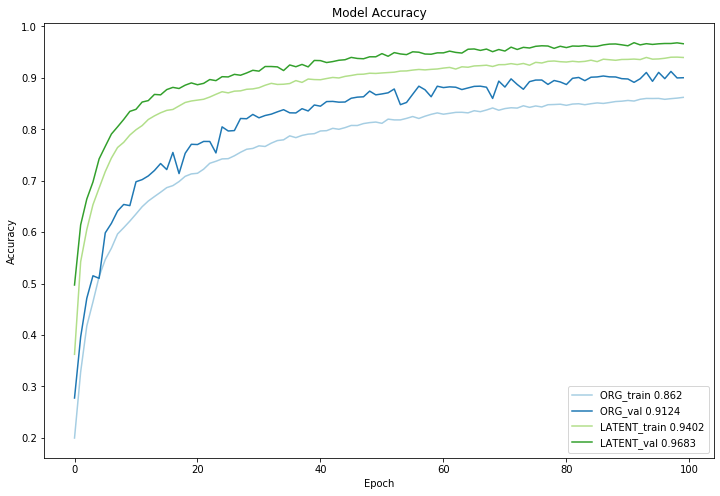

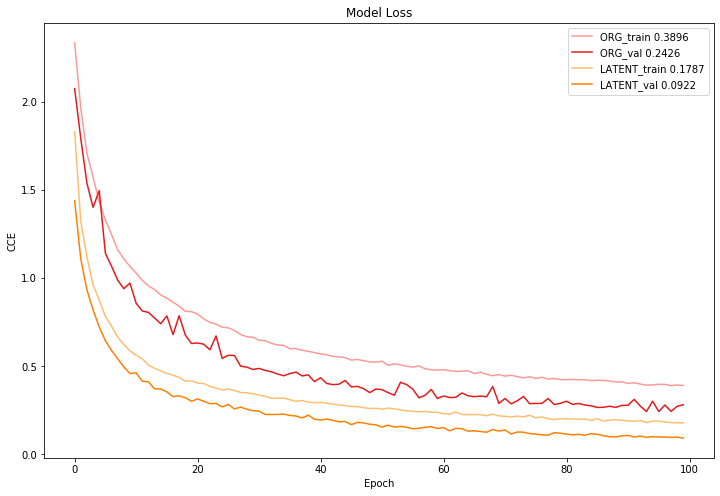

In [0]:
import seaborn as sns
colors = sns.color_palette('Paired', n_colors=8)  

# Plot training & validation MAE values
plt.figure(figsize=(12,8))
names = ['ORG_train', 'ORG_val', 'LATENT_train', 'LATENT_val']
for acc, c, name in zip([h1_tacc, h1_vacc, h2_tacc, h2_vacc], colors[:4], names):
    plt.plot(range(len(acc)), acc, c=c, label=name+" "+str(round(max(acc), 4)))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12,8))
names = ['ORG_train', 'ORG_val', 'LATENT_train', 'LATENT_val']
for loss, c, name in zip([h1_tloss, h1_vloss, h2_tloss, h2_vloss], colors[-4:], names):
    plt.plot(range(len(loss)), loss, c=c, label=name+" "+str(round(min(loss), 4)))
plt.title('Model Loss')
plt.ylabel('CCE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import classification_report

em_preds = model_2.predict(val_input)
em_pred_labels = []
for _ in range(em_preds.shape[0]):
    em_pred_labels.append(np.argmax(em_preds[_]))

em_labels = []
for _ in range(val_label.shape[0]): 
    em_labels.append(np.argmax(val_label[_]))

In [43]:
print(classification_report(em_labels, em_pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2942
           1       0.94      0.94      0.94      1510
           2       1.00      1.00      1.00      2349
           3       0.97      0.98      0.98      2540
           4       0.98      0.96      0.97      4804
           5       0.96      0.96      0.96      1833
           6       0.94      0.99      0.96       703
           7       0.94      0.88      0.91       665
           8       0.98      1.00      0.99      2805
           9       1.00      1.00      1.00      2082
          10       1.00      1.00      1.00      1767
          11       0.97      1.00      0.98      4190
          12       1.00      1.00      1.00       806
          13       0.88      0.90      0.89      1468
          14       0.95      0.92      0.94      2305

    accuracy                           0.97     32769
   macro avg       0.96      0.96      0.96     32769
weighted avg       0.97   

In [46]:
org_preds = model_1.predict(val_input)
org_pred_labels = []
for _ in range(org_preds.shape[0]):
    org_pred_labels.append(np.argmax(org_preds[_]))

org_labels = []
for _ in range(val_label.shape[0]): 
    org_labels.append(np.argmax(val_label[_]))

print(classification_report(org_labels, org_pred_labels))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2925
           1       0.82      0.82      0.82      1522
           2       1.00      1.00      1.00      2299
           3       0.92      0.94      0.93      2411
           4       0.93      0.86      0.90      4696
           5       0.77      0.90      0.83      1822
           6       0.80      0.96      0.87       671
           7       0.94      0.55      0.69       647
           8       0.92      0.97      0.95      2716
           9       1.00      1.00      1.00      2034
          10       1.00      1.00      1.00      1720
          11       0.90      0.98      0.94      4291
          12       1.00      1.00      1.00       755
          13       0.69      0.63      0.66      1416
          14       0.88      0.75      0.81      2378

    accuracy                           0.90     32303
   macro avg       0.89      0.88      0.88     32303
weighted avg       0.90   